## Super resolution

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
torch.cuda.set_device(2)

### Sizes of images: 

- HR images: (3, 1004, 1344)
- LR images: (3, 500, 669)

In [4]:
path = Path('../../../../../SCRATCH2/marvande/data/train/HR/')

path_lr = path / 'small-96/train'
path_mr = path / 'small-256/train'

path_hr = path / 'HR_patches_train/jpg_images'
#path_lr = path/'HR_patches_resized/jpg_images'

assert path.exists(), f"need dataset @ {path}"
assert path_hr.exists()

In [8]:
il = ImageList.from_folder(path_hr)
ImageList.from_folder(path_hr)

ImageList (6168 items)
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/HR_patches_train/jpg_images

In [9]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [10]:
# create smaller image sets the first time this nb is run:
sets = [(path_lr, 96), (path_mr, 256)]
for p, size in sets:
    if not p.exists():
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)


Creates two set of images from the HR images:
- HR: (3, 1004, 1344)
- LR: (3,96,128)
- MR: (3,256, 342)

In [11]:
ImageImageList.from_folder(path_mr)

ImageImageList (1542 items)
Image (3, 256, 342),Image (3, 256, 342),Image (3, 256, 342),Image (3, 256, 342),Image (3, 256, 342)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-256/train

In [12]:
ImageImageList.from_folder(path_lr)

ImageImageList (1542 items)
Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-96/train

In [13]:
# set image size and batch size to which data is transformed:
bs, size = 32, 128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)
src

ItemLists;

Train: ImageImageList (1388 items)
Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-96/train;

Valid: ImageImageList (154 items)
Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-96/train;

Test: None

In [15]:
src.label_from_func(lambda x: path_hr / x.relative_to(path_lr))

FileNotFoundError: [Errno 2] No such file or directory: '/SCRATCH2/marvande/data/train/HR/HR_patches_train/jpg_images/0015_[45120,16718]_-0.jpg'

In [58]:
# Remove affine transformations:
tfms = ([
    RandTransform(tfm=TfmCrop(crop_pad),
                  kwargs={
                      'row_pct': (0, 1),
                      'col_pct': (0, 1),
                      'padding_mode': 'reflection'
                  },
                  p=1.0,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True),
    RandTransform(tfm=TfmPixel(flip_lr),
                  kwargs={},
                  p=0.5,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True),
    RandTransform(tfm=TfmCoord(symmetric_warp),
                  kwargs={'magnitude': (-0.2, 0.2)},
                  p=0.75,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True),
    RandTransform(tfm=TfmLighting(brightness),
                  kwargs={'change': (0.4, 0.6)},
                  p=0.75,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True),
    RandTransform(tfm=TfmLighting(contrast),
                  kwargs={'scale': (0.8, 1.25)},
                  p=0.75,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True)
], [
    RandTransform(tfm=TfmCrop(crop_pad),
                  kwargs={},
                  p=1.0,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True)
])


# Change data to (3,128,128)

def get_data(bs, size):
    #label_from_func: apply func to every input to get its label.
    data = (src.label_from_func(
        lambda x: path_hr / x.relative_to(path_lr)).transform(
            tfms, size=size,
            tfm_y=True).databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

Comments: 
- here seem to normalize to imagenet_stats --> is that ok ? 


Create training data of the shape (3, 128, 128):

In [59]:
data = get_data(bs,size)
data

ImageDataBunch;

Train: LabelList (1388 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-96/train;

Valid: LabelList (154 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-96/train;

Test: None

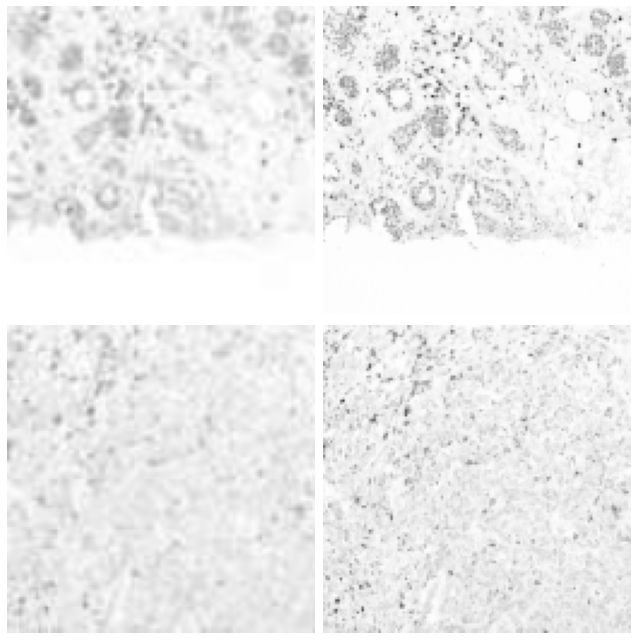

In [60]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [61]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [62]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [63]:
gram_matrix(t)

tensor([[[0.2937, 0.2937, 0.2937],
         [0.2937, 0.2937, 0.2937],
         [0.2937, 0.2937, 0.2937]],

        [[0.2937, 0.2937, 0.2937],
         [0.2937, 0.2937, 0.2937],
         [0.2937, 0.2937, 0.2937]]])

In [64]:
base_loss = F.l1_loss

In [65]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [66]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [67]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [68]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [69]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

In [47]:
"""
# if problems with memory, restart run this, restart kernel:
torch.cuda.empty_cache()
gpu_mem_get_free_no_cache
learn.destroy()
"""

'\n# if problems with memory, restart run this, restart kernel:\ntorch.cuda.empty_cache()\ngpu_mem_get_free_no_cache\nlearn.destroy()\n'

In [70]:
def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(type(obj), obj.size())
    
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)

#cpuStats()
#memReport()

In [71]:
torch.cuda.device_count()
torch.cuda.current_stream()
torch.cuda.is_available()

True

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


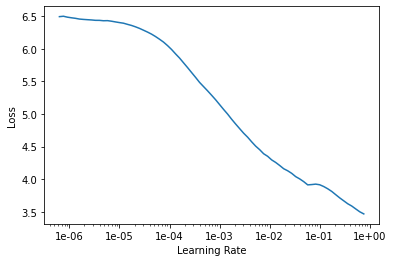

In [72]:
learn.lr_find()
learn.recorder.plot()

In [73]:
lr = 1e-3

In [74]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.366554,1.854741,0.188596,0.206728,0.234913,0.036893,0.496173,0.672130,0.019310,00:27
1,1.741204,1.317509,0.169707,0.173147,0.188266,0.028295,0.285062,0.458870,0.014162,00:26
2,1.419170,1.245684,0.169378,0.168052,0.185098,0.026289,0.255239,0.428415,0.013211,00:25
3,1.288230,1.235944,0.173607,0.166817,0.181170,0.026097,0.256657,0.418581,0.013015,00:26
4,1.260213,1.268349,0.194808,0.163536,0.181892,0.026409,0.263238,0.425233,0.013233,00:25
5,1.225243,1.168232,0.186599,0.159099,0.172633,0.024420,0.225149,0.388180,0.012153,00:26
6,1.358929,1.223222,0.156065,0.165951,0.180752,0.027083,0.259270,0.420375,0.013725,00:26
7,1.370551,1.217823,0.184452,0.164324,0.179890,0.025757,0.243536,0.406904,0.012960,00:26
8,1.245654,1.131945,0.161273,0.160432,0.172724,0.024460,0.216371,0.384437,0.012248,00:26
9,1.171831,1.086652,0.143371,0.157846,0.170812,0.024085,0.204116,0.374424,0.011999,00:26


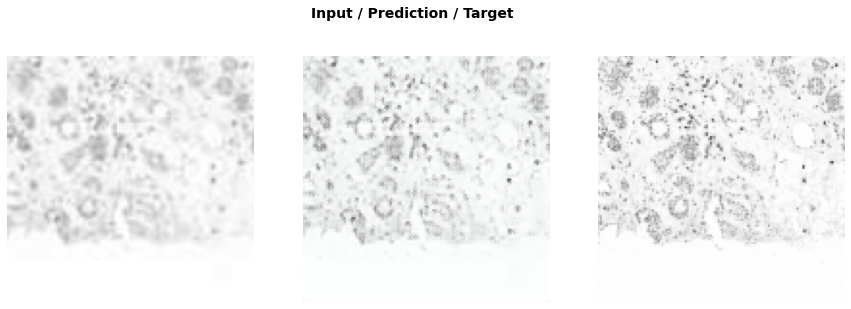

In [75]:
do_fit('1a', slice(lr*10))

In [76]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.092758,1.080479,0.142637,0.157457,0.170683,0.024025,0.201930,0.371781,0.011965,00:27
1,1.092621,1.079088,0.142946,0.157723,0.170765,0.023987,0.199932,0.371803,0.011932,00:27
2,1.092853,1.075910,0.143673,0.157291,0.170416,0.023896,0.198555,0.370195,0.011884,00:27
3,1.086785,1.075536,0.142258,0.156874,0.169795,0.023869,0.200678,0.370180,0.011882,00:26
4,1.082280,1.062860,0.142695,0.156033,0.169443,0.023656,0.194075,0.365197,0.011761,00:27
5,1.076928,1.060440,0.140877,0.155925,0.169624,0.023557,0.194249,0.364495,0.011714,00:26
6,1.071746,1.055709,0.141737,0.155039,0.168414,0.023546,0.194133,0.361145,0.011694,00:27
7,1.069555,1.054475,0.147554,0.155108,0.167806,0.023384,0.188894,0.360169,0.011559,00:27
8,1.066667,1.045220,0.141345,0.154396,0.168046,0.023473,0.187718,0.358553,0.011689,00:27
9,1.056908,1.036691,0.141022,0.153886,0.167033,0.023256,0.184889,0.355079,0.011526,00:26


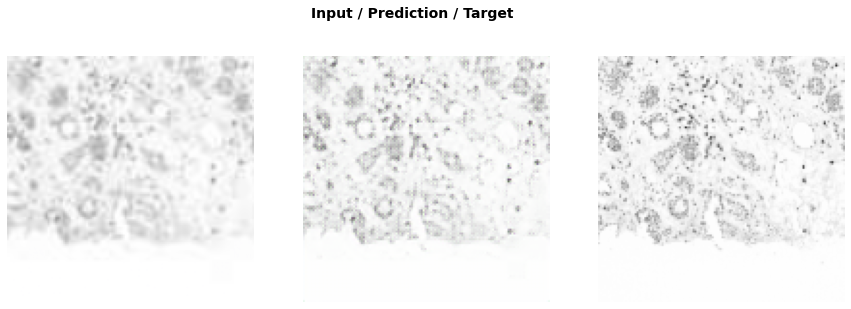

In [77]:
do_fit('1b', slice(1e-5,lr))

In [78]:
data = get_data(12,size*2)

In [79]:
learn.data = data
learn.freeze()
gc.collect()

20903

In [80]:
data

ImageDataBunch;

Train: LabelList (1388 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-96/train;

Valid: LabelList (154 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-96/train;

Test: None

In [81]:
learn.load('1b');

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.365686,1.305985,0.171287,0.237462,0.206572,0.031878,0.355258,0.290441,0.013087,01:45
1,1.201394,1.150790,0.176885,0.227912,0.197996,0.028530,0.251148,0.256535,0.011784,01:33
2,1.132345,1.105403,0.175626,0.223235,0.193992,0.027856,0.227692,0.245476,0.011526,01:33
3,1.106832,1.081258,0.177932,0.219958,0.192100,0.027442,0.213751,0.238713,0.011362,01:33
4,1.087168,1.068335,0.172006,0.217272,0.188915,0.027093,0.214585,0.237170,0.011294,01:33
5,1.078939,1.060744,0.173854,0.217951,0.189786,0.027418,0.207667,0.232708,0.011361,01:33
6,1.078493,1.058665,0.175462,0.216155,0.188968,0.027117,0.203614,0.236035,0.011314,01:33
7,1.072658,1.056381,0.173155,0.216245,0.187838,0.027111,0.206978,0.233816,0.011238,01:33
8,1.068704,1.040639,0.173653,0.215480,0.186859,0.026789,0.198277,0.228374,0.011208,01:33
9,1.049253,1.025947,0.170011,0.214433,0.186027,0.027052,0.193441,0.223723,0.011260,01:33


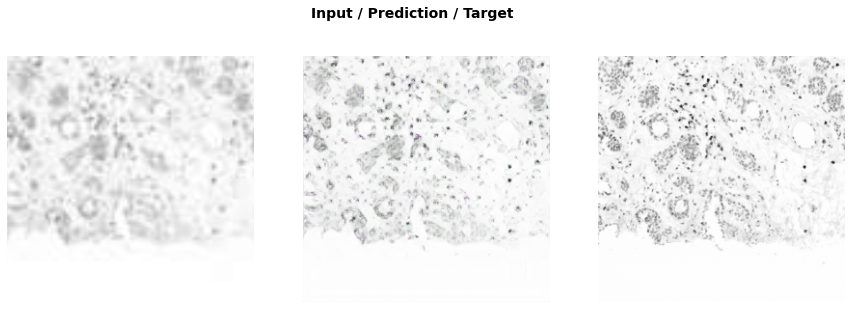

In [82]:
do_fit('2a')

In [83]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.038967,1.026531,0.169693,0.214326,0.186765,0.027069,0.193574,0.223834,0.011270,01:37
1,1.035029,1.023527,0.169847,0.214328,0.186191,0.026978,0.191504,0.223469,0.011211,01:36
2,1.034307,1.020831,0.170883,0.214237,0.186584,0.027046,0.189157,0.221704,0.011220,01:36
3,1.036924,1.021357,0.170027,0.214044,0.185781,0.026887,0.189855,0.223568,0.011195,01:36
4,1.032956,1.019020,0.171483,0.213723,0.186101,0.026883,0.187915,0.221736,0.011179,01:36
5,1.035979,1.016115,0.170840,0.213454,0.185410,0.026897,0.189041,0.219316,0.011158,01:36
6,1.030303,1.014394,0.169581,0.213920,0.185585,0.026847,0.187764,0.219563,0.011134,01:36
7,1.026800,1.012671,0.170877,0.213471,0.185332,0.026805,0.186628,0.218434,0.011124,01:37
8,1.030395,1.014015,0.170323,0.213684,0.185019,0.026826,0.188130,0.218895,0.011139,01:36
9,1.028786,1.013023,0.170009,0.213388,0.185700,0.026833,0.187480,0.218478,0.011134,01:36


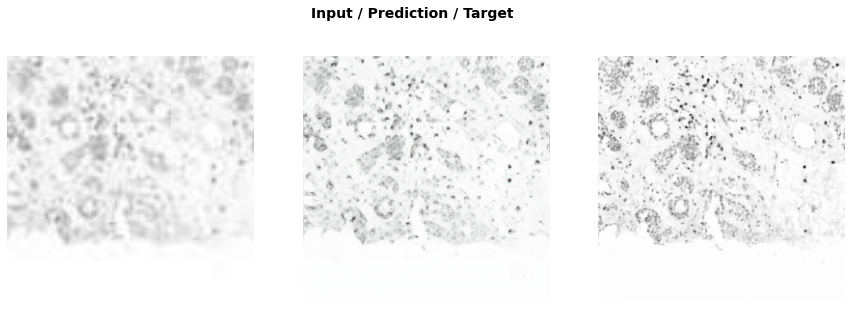

In [84]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [85]:
learn = None
gc.collect();

In [86]:
256/320*1024

819.2

In [87]:
256/320*1600

1280.0

In [88]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(820, 1024), have 5514MB of GPU RAM free


In [89]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [90]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(tfms, size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [91]:
data_mr

ImageDataBunch;

Train: LabelList (1388 items)
x: ImageImageList
Image (3, 820, 1024),Image (3, 820, 1024),Image (3, 820, 1024),Image (3, 820, 1024),Image (3, 820, 1024)
y: ImageList
Image (3, 820, 1024),Image (3, 820, 1024),Image (3, 820, 1024),Image (3, 820, 1024),Image (3, 820, 1024)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-256/train;

Valid: LabelList (154 items)
x: ImageImageList
Image (3, 820, 1024),Image (3, 820, 1024),Image (3, 820, 1024),Image (3, 820, 1024),Image (3, 820, 1024)
y: ImageList
Image (3, 820, 1024),Image (3, 820, 1024),Image (3, 820, 1024),Image (3, 820, 1024),Image (3, 820, 1024)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-256/train;

Test: None

In [92]:
learn.load('2b');

In [93]:
learn.data = data_mr

In [94]:
fn = data_mr.valid_ds.x.items[0]; fn

PosixPath('../../../../../SCRATCH2/marvande/data/train/HR/small-256/train/0015_[37753,20968]_-1.jpg')

In [95]:
img = open_image(fn); img.shape

torch.Size([3, 256, 342])

In [96]:
p,img_hr,b = learn.predict(img)

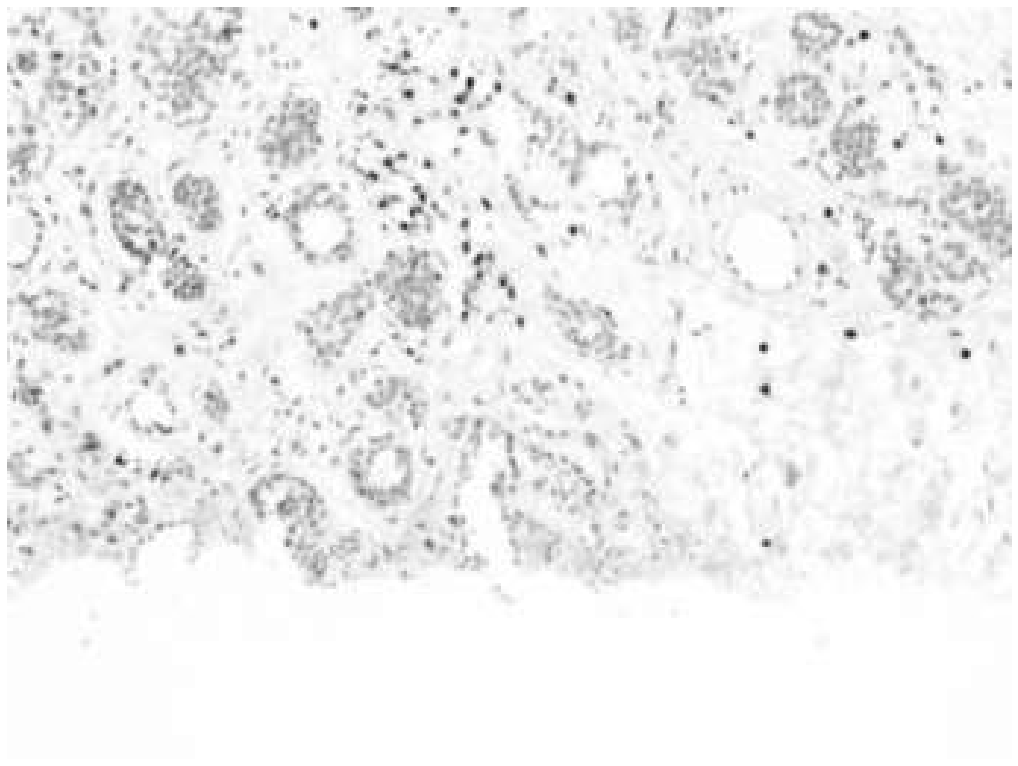

In [97]:
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


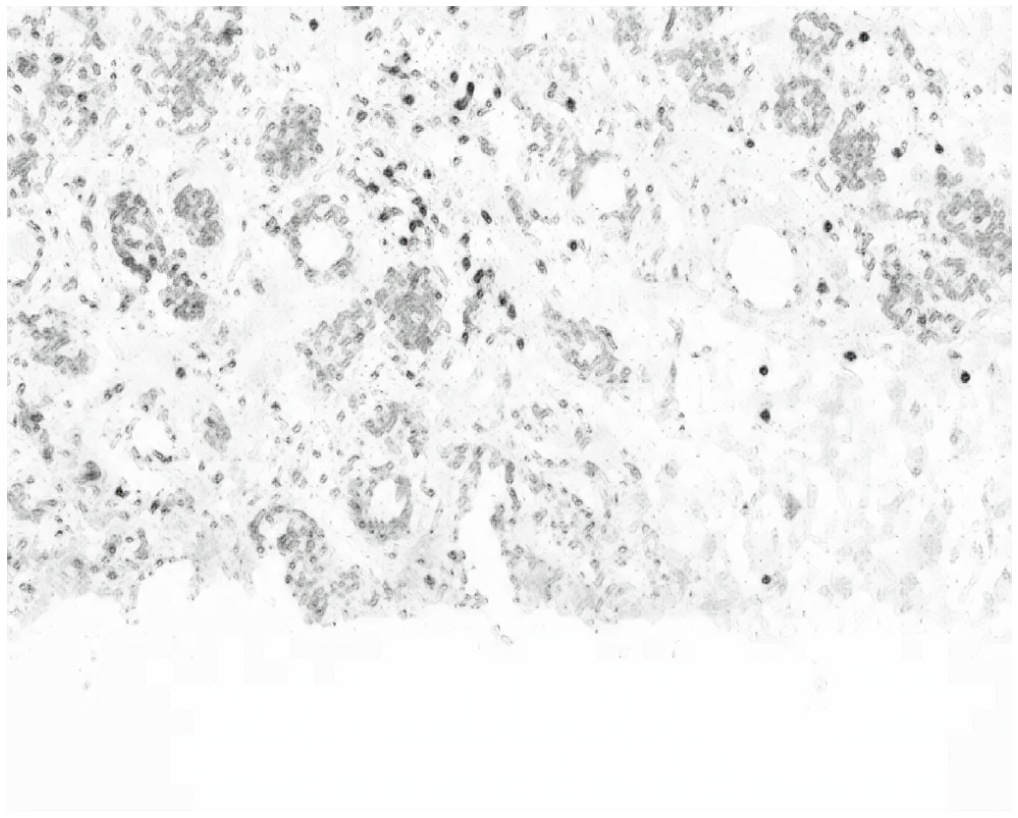

In [98]:
Image(img_hr).show(figsize=(18,15))